In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:

from flask import Flask, jsonify

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
inspector = inspect(engine)
inspector.get_table_names()


['measurement', 'station']

In [12]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [14]:
session.query(func.count(Measurement.date)).all()


[(19550)]

In [15]:
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

In [16]:
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [17]:
#retrive date to make a year from desc date
query_date = dt.date(2017,8,23) - dt.timedelta(days=364)
query_date


datetime.date(2016, 8, 24)

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and lot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores

sel = [Measurement.date, Measurement.prcp]

whole_query_dates = session.query(*sel).\
    filter(Measurement.date.between('2016-08-23', '2017-08-23')).all()

query_dates = session.query(*sel).\
    filter(Measurement.date.between('2016-08-23', '2017-08-23')).\
    group_by(Measurement.date).all()
query_dates

[('2016-08-23', 0.7),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.01),
 ('2016-08-27', None),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.9),
 ('2016-08-30', 0.05),
 ('2016-08-31', 2.46),
 ('2016-09-01', 0.01),
 ('2016-09-02', 0.03),
 ('2016-09-03', 1.0),
 ('2016-09-04', 0.44),
 ('2016-09-05', 0.18),
 ('2016-09-06', 1.0),
 ('2016-09-07', 1.35),
 ('2016-09-08', 0.15),
 ('2016-09-09', 0.35),
 ('2016-09-10', 1.16),
 ('2016-09-11', 0.6),
 ('2016-09-12', 1.04),
 ('2016-09-13', 1.2),
 ('2016-09-14', 6.7),
 ('2016-09-15', 3.35),
 ('2016-09-16', 0.61),
 ('2016-09-17', 0.23),
 ('2016-09-18', 0.42),
 ('2016-09-19', 0.25),
 ('2016-09-20', 0.43),
 ('2016-09-21', 1.02),
 ('2016-09-22', 0.75),
 ('2016-09-23', 0.33),
 ('2016-09-24', 0.27),
 ('2016-09-25', 0.04),
 ('2016-09-26', 1.02),
 ('2016-09-27', 1.0),
 ('2016-09-28', 0.05),
 ('2016-09-29', 1.49),
 ('2016-09-30', 0.38),
 ('2016-10-01', 1.02),
 ('2016-10-02', 0.61),
 ('2016-10-03', 0.46),
 ('2016-10-04', 3.46),
 ('2016-10-05', 0.8

In [19]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(query_dates, columns = ['date', 'precipitation'])
prcp_df.set_index('date', inplace=True)

prcp_df.head()

,precipitation
date,
2016-08-23,0.70
2016-08-24,1.45
2016-08-25,0.11
2016-08-26,0.01
2016-08-27,NaN


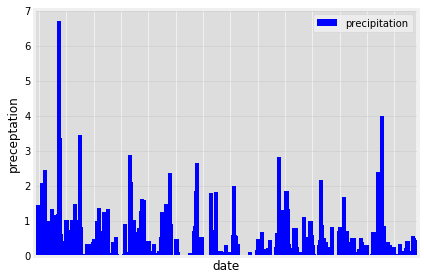

In [20]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(kind='bar', y='precipitation', color= 'blue', width=4)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('preceptation')
plt.tight_layout()
plt.grid(linestyle='-', linewidth='0.5')
plt.show()


![precipitation](Images/precipitation.png)

In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data
#with the groupby
prcp_df.describe()

,precipitation
count,345.000000
mean,0.432087
std,0.704363
min,0.000000
25%,0.010000
50%,0.140000
75%,0.580000
max,6.700000


In [22]:
ungroupedprcp_df = pd.DataFrame(whole_query_dates, columns = ['date', 'precipitation'])
ungroupedprcp_df.set_index('date', inplace=True)

ungroupedprcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [23]:
#count
count_query=  session.query(*sel).\
    filter(Measurement.station == Station.station).\
    group_by(Station.station).count()


count_query

9

In [24]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Station.id, Measurement.station, func.count(Measurement.station).label('count')).\
filter(Measurement.station == Station.station).\
group_by(Measurement.station).\
order_by(desc('count')).all()

[(7, 'USC00519281', 2772),
 (1, 'USC00519397', 2724),
 (2, 'USC00513117', 2709),
 (6, 'USC00519523', 2669),
 (9, 'USC00516128', 2612),
 (3, 'USC00514830', 2202),
 (8, 'USC00511918', 1979),
 (4, 'USC00517948', 1372),
 (5, 'USC00518838', 511)]

In [25]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [Station.id, Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
lowhighavg_query = session.query(*sel).\
filter(Measurement.station == Station.station).\
filter(Station.id == 7).all()
lowhighavg_query

[(7, 'USC00519281', 54.0, 85.0, 71.66378066378067)]

In [26]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.date, Measurement.tobs]

query_tobs = session.query(*sel).\
filter(Measurement.station == Station.station).\
filter(Station.id == 7).\
filter(Measurement.date.between('2016-08-23', '2017-08-23')).\
group_by(Measurement.date).all()
query_tobs

[('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-

In [27]:
temp_df = pd.DataFrame(query_tobs, columns = ['date', 'temp'])
temp_df.set_index('date', inplace=True)

temp_df.head()

,temp
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


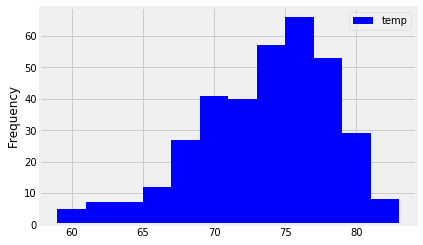

In [28]:
temp_df.plot(kind='hist', y='temp', bins=12, color= 'blue')
plt.show()

![precipitation](Images/station-histogram.png)

In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[('2012-02-29', 62.0, 69.57142857142857, 74.0)]


In [30]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calctemp = calc_temps('2016-08-23', '2017-08-23')

In [31]:
calctemp_df = pd.DataFrame(calctemp, columns = ['date','mintob', 'avgtob', 'maxtob'])
calctemp_df.set_index('date', inplace=True)

calctemp_df.head()

,mintob,avgtob,maxtob
date,,,
2017-05-23,58.0,74.590583,87.0


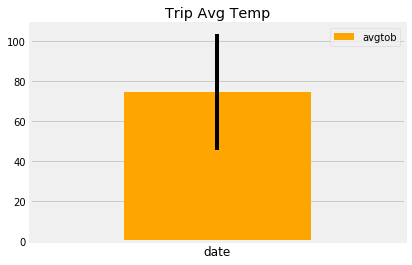

In [32]:
# Plot the results from your previous query as a bar chart. 
y_error = calctemp_df['maxtob'] - calctemp_df['mintob']
calctemp_df.plot(kind='bar', y='avgtob',yerr=y_error, color= 'orange')
plt.xticks([])
plt.title('Trip Avg Temp')
plt.show()
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [33]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp).label('total')).\
        filter(Measurement.station == Station.station).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
        group_by(Measurement.station).order_by(desc('total')).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))


[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 11.08), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 10.32), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 5.79), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 3.8400000000000003), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 2.92), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 1.1800000000000002), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.76), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.03), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)]


## Optional Challenge Assignment

In [34]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("08-20")    
    

[(68.0, 76.45283018867924, 82.0)]

In [35]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`



# Set the start and end date of the trip
def normal_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
    group_by(Measurement.station).all()

# function usage example
normal_temps('2012-02-28', '2012-03-05')


       ## normals.append({tripdate[0]:tripdate[1]})
        
    ##return(normals)

# Use the start and end date to create a range of dates


# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
#print(normal_temps('2016-01-01','2016-01-07'))


[('2012-02-29', 64.0, 69.85714285714286, 74.0),
 ('2012-02-29', 65.0, 69.57142857142857, 72.0),
 ('2012-03-02', 66.0, 69.0, 71.0),
 ('2012-02-28', 64.0, 66.85714285714286, 69.0),
 ('2012-03-02', 70.0, 72.5, 74.0),
 ('2012-02-29', 62.0, 67.4, 74.0),
 ('2012-03-01', 65.0, 69.14285714285714, 71.0),
 ('2012-02-29', 67.0, 71.0, 74.0),
 ('2012-02-29', 67.0, 71.28571428571429, 73.0)]

In [36]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
Normals = normal_temps('2017-08-01', '2017-08-10')
normaltemp_df = pd.DataFrame(Normals, columns = ['date','mintob', 'avgtob', 'maxtob'])
normaltemp_df.set_index('date', inplace=True)

normaltemp_df.head()

,mintob,avgtob,maxtob
date,,,
2017-08-06,74.0,79.888889,82.0
2017-08-02,71.0,75.777778,80.0
2017-08-06,77.0,80.666667,83.0
2017-08-05,73.0,79.100000,81.0
2017-08-02,75.0,81.000000,83.0


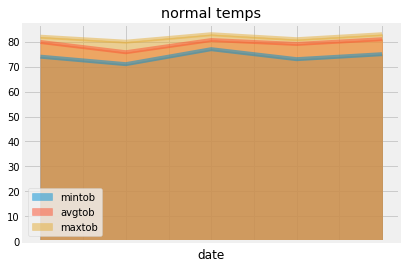

In [38]:
# Plot the daily normals as an area plot with `stacked=False`
normaltemp_df.plot(kind='area', stacked=False, title= "normal temps")

plt.show()